In [1]:
!pip install biopython pandas numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.4 MB/s eta 0:00:00


In [2]:
from Bio import Entrez
import os

Entrez.email = "herutriana44@gmail.com"
Entrez.tool = "dengue_mutation_project"

target_dir = "dengue_virus_genome_data"
os.makedirs(target_dir, exist_ok=True)

In [3]:
def search_dengue_genbank(retmax=5000):
    query = (
        'Dengue virus[Organism] AND '
        '(complete genome[Title] OR genome[Title])'
    )

    handle = Entrez.esearch(
        db="nucleotide",
        term=query,
        retmax=retmax
    )
    record = Entrez.read(handle)
    handle.close()

    return record["IdList"]


In [4]:
from Bio import SeqIO
from io import StringIO

def fetch_genbank_records(id_list):
    handle = Entrez.efetch(
        db="nucleotide",
        id=",".join(id_list),
        rettype="gb",
        retmode="text"
    )
    records = list(SeqIO.parse(handle, "genbank"))
    handle.close()
    return records


In [5]:
import re

def infer_serotype(record):
    text = " ".join(filter(None, [
        record.description,
        record.annotations.get("organism", ""),
        record.annotations.get("source", "")
    ])).lower()

    print(f"text : {text}")

    patterns = [
        r"dengue virus type\s*([1-4])",
        r"dengue virus\s*([1-4])",
        r"type[-\s]*([1-4])",
        r"serotype[-\s]*([1-4])",
        r"denv[-\s]*([1-4])",
        r"den[-\s]*([1-4])"
    ]

    for pattern in patterns:
        match = re.search(pattern, text)
        print(f"pattern : {pattern}")
        print(f"match : {match}")
        if match:
            return f"DENV-{match.group(1)}"

    return None


In [23]:
import pandas as pd

def extract_metadata(records):
    rows = []

    for rec in records:
        qualifiers = rec.annotations
        features = rec.features

        serotype = infer_serotype(rec)
        genotype = None
        country = None
        year = None
        host = None

        for feat in features:
            if feat.type == "source":
                q = feat.qualifiers
                # serotype = q.get("serotype", [None])[0]
                genotype = q.get("genotype", [None])[0]
                country = q.get("country", [None])[0]
                host = q.get("host", [None])[0]

                if "collection_date" in q:
                    year = q["collection_date"][0][-4:]

        rows.append({
            "sample_id": rec.id,
            "description": rec.description,
            "serotype": serotype,
            "genotype": genotype,
            "country": country,
            "year": year,
            "host": host,
            "genome_length": len(rec.seq),
            "is_complete": "complete genome" in rec.description.lower()
        })

    return pd.DataFrame(rows)


In [24]:
from Bio.Seq import UndefinedSequenceError

def extract_sequences(records, min_length=9000):
    rows = []
    skipped = 0

    for rec in records:
        try:
            seq = rec.seq

            # cek sequence valid
            if seq is None:
                skipped += 1
                continue

            seq_str = str(seq)

            # QC dasar
            if len(seq_str) < min_length:
                skipped += 1
                continue

            rows.append({
                "sample_id": rec.id,
                "sequence": seq_str
            })

        except UndefinedSequenceError:
            skipped += 1
            continue
        except Exception as e:
            skipped += 1
            continue

    print(f"Skipped records due to undefined/invalid sequence: {skipped}")
    return pd.DataFrame(rows)


In [25]:
from collections import Counter
import numpy as np

def gc_content(seq):
    seq = seq.upper()
    return (seq.count("G") + seq.count("C")) / len(seq)

def kmer_features(seq, k=3):
    counts = Counter(
        seq[i:i+k] for i in range(len(seq)-k+1)
        if "N" not in seq[i:i+k]
    )
    total = sum(counts.values())
    return {f"kmer_{kmer}": v/total for kmer, v in counts.items()}


In [26]:
def build_sequence_features(seq_df, k=3):
    rows = []

    for _, row in seq_df.iterrows():
        feats = {
            "sample_id": row["sample_id"],
            "gc_content": gc_content(row["sequence"])
        }
        feats.update(kmer_features(row["sequence"], k=k))
        rows.append(feats)

    return pd.DataFrame(rows).fillna(0)


In [27]:
def mutation_summary_placeholder(seq_df, reference_length=10700):
    rows = []

    for _, row in seq_df.iterrows():
        seq_len = len(row["sequence"])
        rows.append({
            "sample_id": row["sample_id"],
            "length_diff": seq_len - reference_length,
            "mutation_density": abs(seq_len - reference_length) / reference_length
        })

    return pd.DataFrame(rows)


In [28]:
def build_label_table(metadata_df):
    df = metadata_df[["sample_id", "serotype", "genotype"]].copy()
    df["known_genotype"] = df["genotype"].notnull()
    return df


In [29]:
from tqdm import tqdm

ids = search_dengue_genbank(retmax=2000)
records = fetch_genbank_records(ids)

metadata_df = extract_metadata(records)
sequence_df = extract_sequences(records)
sequence_features_df = build_sequence_features(sequence_df, k=3)
mutation_df = mutation_summary_placeholder(sequence_df)
label_df = build_label_table(metadata_df)


text : dengue virus type 4 isolate d20-0259, complete genome dengue virus type 4 dengue virus type 4
pattern : dengue virus type\s*([1-4])
match : <re.Match object; span=(0, 19), match='dengue virus type 4'>
text : dengue virus type 4 isolate d20-0040, complete genome dengue virus type 4 dengue virus type 4
pattern : dengue virus type\s*([1-4])
match : <re.Match object; span=(0, 19), match='dengue virus type 4'>
text : dengue virus type 4 isolate d19-2229, complete genome dengue virus type 4 dengue virus type 4
pattern : dengue virus type\s*([1-4])
match : <re.Match object; span=(0, 19), match='dengue virus type 4'>
text : dengue virus type 4 isolate d19-1649, complete genome dengue virus type 4 dengue virus type 4
pattern : dengue virus type\s*([1-4])
match : <re.Match object; span=(0, 19), match='dengue virus type 4'>
text : dengue virus type 4 isolate d19-1286, complete genome dengue virus type 4 dengue virus type 4
pattern : dengue virus type\s*([1-4])
match : <re.Match object; spa

In [30]:
print(records[0])

ID: PX480447.1
Name: PX480447
Description: Dengue virus type 4 isolate D20-0259, complete genome
Number of features: 26
/molecule_type=RNA
/topology=linear
/data_file_division=VRL
/date=31-DEC-2025
/accessions=['PX480447']
/sequence_version=1
/keywords=['']
/source=dengue virus type 4
/organism=dengue virus type 4
/taxonomy=['Viruses', 'Riboviria', 'Orthornavirae', 'Kitrinoviricota', 'Flasuviricetes', 'Amarillovirales', 'Flaviviridae', 'Orthoflavivirus', 'Orthoflavivirus denguei']
/references=[Reference(title='Direct Submission', ...)]
/structured_comment=defaultdict(<class 'dict'>, {'Assembly-Data': {'Assembly Method': 'https://github.com/jodyphelan/dengue-ngs v. APRIL-2024', 'Sequencing Technology': 'Illumina'}})
Seq('AGTTGTTAGTCTGTGTGGACCGACAAGGACAGTTCCAAATCGGAAGCTTGCTTA...TCT')


In [31]:
metadata_df.to_csv(os.path.join(target_dir, "sample_metadata.csv"), index=False)
sequence_df.to_csv(os.path.join(target_dir, "raw_sequences.csv"), index=False)
sequence_features_df.to_csv(os.path.join(target_dir, "sequence_features.csv"), index=False)
mutation_df.to_csv(os.path.join(target_dir, "mutation_profile.csv"), index=False)
label_df.to_csv(os.path.join(target_dir, "label_table.csv"), index=False)

In [32]:
!zip -r dengue_virus_genome_data.zip dengue_virus_genome_data

updating: dengue_virus_genome_data/ (stored 0%)
updating: dengue_virus_genome_data/sample_metadata.csv (deflated 89%)
updating: dengue_virus_genome_data/sequence_features.csv (deflated 87%)
updating: dengue_virus_genome_data/label_table.csv (deflated 86%)
updating: dengue_virus_genome_data/raw_sequences.csv (deflated 88%)
updating: dengue_virus_genome_data/mutation_profile.csv (deflated 87%)


In [33]:
# download dengue_virus_genome_data.zip
from google.colab import files
files.download('dengue_virus_genome_data.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
metadata_df

,sample_id,description,serotype,genotype,country,year,host,genome_length,is_complete
0,PX480447.1,"Dengue virus type 4 isolate D20-0259, complete...",DENV-4,None,None,7-28,Homo sapiens,10649,True
1,PX480446.1,"Dengue virus type 4 isolate D20-0040, complete...",DENV-4,None,None,0-31,Homo sapiens,10649,True
2,PX480445.1,"Dengue virus type 4 isolate D19-2229, complete...",DENV-4,None,None,8-29,Homo sapiens,10649,True
3,PX480444.1,"Dengue virus type 4 isolate D19-1649, complete...",DENV-4,None,None,7-02,Homo sapiens,10649,True
4,PX480443.1,"Dengue virus type 4 isolate D19-1286, complete...",DENV-4,None,None,5-17,Homo sapiens,10649,True
...,...,...,...,...,...,...,...,...,...
1995,KM279515.1,"Dengue virus 2 isolate DC331Y11, complete genome",DENV-2,None,None,2011,Homo sapiens,10723,True
1996,KM279514.1,"Dengue virus 2 isolate DC316Y11, partial genome",DENV-2,None,None,2011,Homo sapiens,10679,False
1997,KM279513.1,"Dengue virus 2 isolate DC311Y11, partial genome",DENV-2,None,None,2011,Homo sapiens,10663,False
1998,KM587709.1,"Dengue virus 2 isolate GW6, complete genome",DENV-2,None,None,2014,None,10713,True


In [35]:
class Dummy:
    description = metadata_df['description'][0]
    annotations = {
        "organism": "Dengue virus type 4",
        "source": "Dengue virus type 4"
    }

print(infer_serotype(Dummy()))


text : dengue virus type 4 isolate d20-0259, complete genome dengue virus type 4 dengue virus type 4
pattern : dengue virus type\s*([1-4])
match : <re.Match object; span=(0, 19), match='dengue virus type 4'>
DENV-4


In [36]:
metadata_df

,sample_id,description,serotype,genotype,country,year,host,genome_length,is_complete
0,PX480447.1,"Dengue virus type 4 isolate D20-0259, complete...",DENV-4,None,None,7-28,Homo sapiens,10649,True
1,PX480446.1,"Dengue virus type 4 isolate D20-0040, complete...",DENV-4,None,None,0-31,Homo sapiens,10649,True
2,PX480445.1,"Dengue virus type 4 isolate D19-2229, complete...",DENV-4,None,None,8-29,Homo sapiens,10649,True
3,PX480444.1,"Dengue virus type 4 isolate D19-1649, complete...",DENV-4,None,None,7-02,Homo sapiens,10649,True
4,PX480443.1,"Dengue virus type 4 isolate D19-1286, complete...",DENV-4,None,None,5-17,Homo sapiens,10649,True
...,...,...,...,...,...,...,...,...,...
1995,KM279515.1,"Dengue virus 2 isolate DC331Y11, complete genome",DENV-2,None,None,2011,Homo sapiens,10723,True
1996,KM279514.1,"Dengue virus 2 isolate DC316Y11, partial genome",DENV-2,None,None,2011,Homo sapiens,10679,False
1997,KM279513.1,"Dengue virus 2 isolate DC311Y11, partial genome",DENV-2,None,None,2011,Homo sapiens,10663,False
1998,KM587709.1,"Dengue virus 2 isolate GW6, complete genome",DENV-2,None,None,2014,None,10713,True


<Axes: xlabel='serotype'>

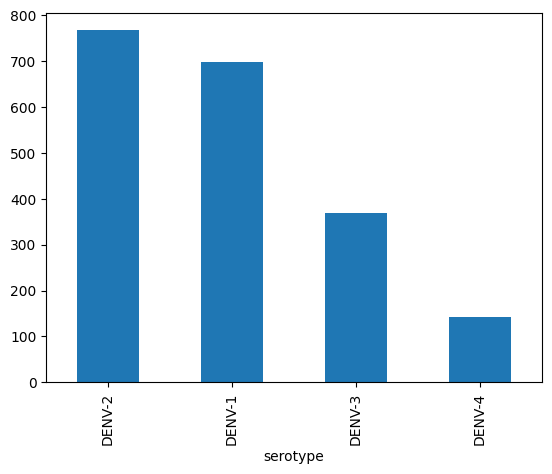

In [37]:
metadata_df['serotype'].value_counts().plot(kind='bar')